# Description:

This employee retention tool kit is for predecting whether or not given employee leave the company, if yes then HR department can take respective actions to retain the employee.

It is a classification problem

# Dataset:

Dataset is avaialable on Kaggle:
https://www.kaggle.com/gummulasrikanth/hr-employee-retention

In [168]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [169]:
dataset_location = r"dataset/employee.csv"
data = pd.read_csv(dataset_location)
data.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [170]:
print(data.columns.values)

['satisfaction_level' 'last_evaluation' 'number_project'
 'average_montly_hours' 'time_spend_company' 'Work_accident' 'left'
 'promotion_last_5years' 'sales' 'salary']


### Column Description:

Each record represents data for an employee

1. satisfaction_level: It represents work satisfaction level of employee
2. last_evaluation: Employee performance in last appraisal cycle
3. number_project: Number of projects that employee worked for
4. average_montly_hours: Average monthly hours spent by employee at work
5. time_spend_company: It is a tenure in years for which an employee worked so far in the company 
6. Work_accident: Number of accidents happened at work by an employee
7. left: Is that individual is still an employee or not
8. promotion_last_5years: Number of promotions in last 5 years for the employee
9. sales: It actually represents the department of the employee
10. salary: Salary of an employee

In [171]:
print("Number of rows and columns in the dataset are {} and {} respectively".format(data.shape[0], data.shape[1]))

Number of rows and columns in the dataset are 14999 and 10 respectively


We will replace Sales column by department as it will be easy to interpret

In [172]:
data.rename(columns={'sales': 'department'}, inplace=True)

In [173]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
department               14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [174]:
data[data.isnull()].count()

satisfaction_level       0
last_evaluation          0
number_project           0
average_montly_hours     0
time_spend_company       0
Work_accident            0
left                     0
promotion_last_5years    0
department               0
salary                   0
dtype: int64

### Observations:

1. Number of columns: 10
2. Number of rows: 14999
3. Number of numeric column: 8
4. Number of categorical column: 2
5. No null values spoted in dataset

# Exploratory Data Analysis

In [175]:
data.groupby('left')['left'].count()

left
0    11428
1     3571
Name: left, dtype: int64

In [176]:
data.groupby('department')['department'].count()

department
IT             1227
RandD           787
accounting      767
hr              739
management      630
marketing       858
product_mng     902
sales          4140
support        2229
technical      2720
Name: department, dtype: int64

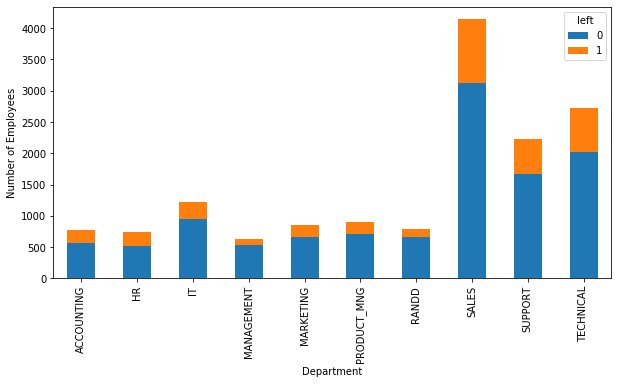

In [185]:
x = pd.crosstab(index = data.department.str.upper(), columns = data.left)

x.plot.bar(stacked=True)
plt.legend(title='left')
plt.xlabel("Department")
plt.ylabel("Number of Employees")
plt.rcParams["figure.figsize"] = (10,3)
plt.show()


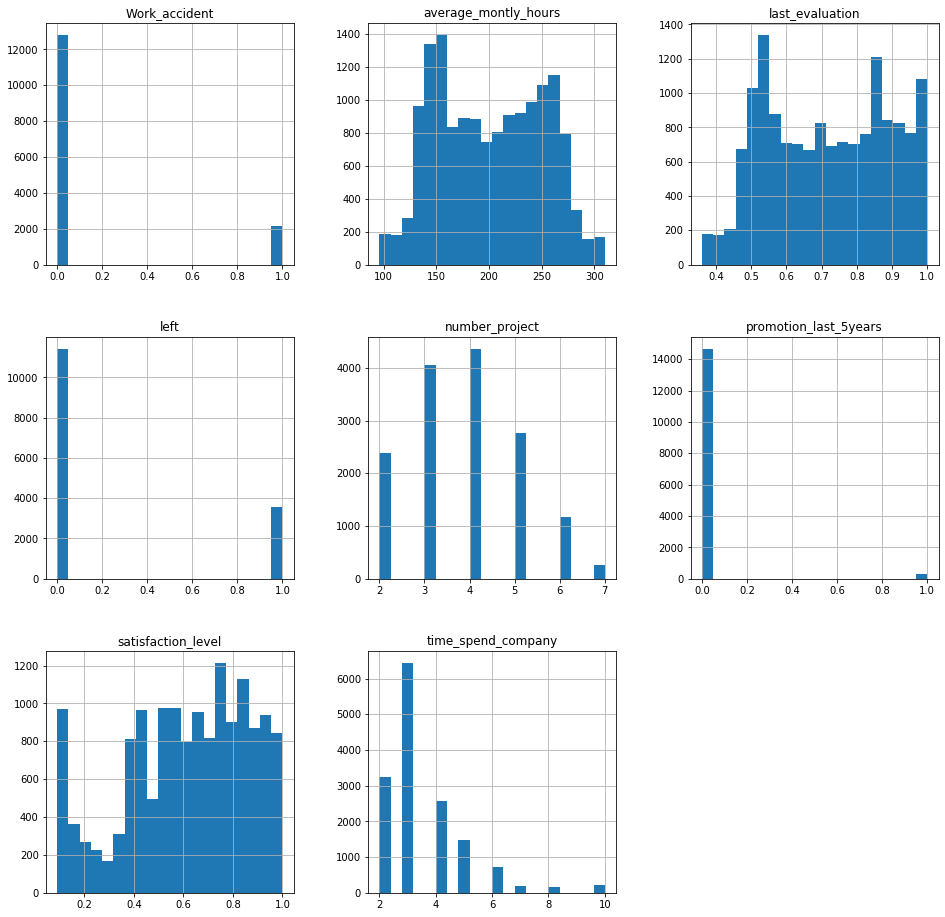

In [181]:
histograms = data.hist(figsize=(16, 16), bins=20)

In [223]:
A = pd.crosstab(data.Work_accident, data.left)
A

left,0,1
Work_accident,,
0,9428,3402
1,2000,169


In [224]:
B = pd.crosstab(data.promotion_last_5years, data.left)
B

left,0,1
promotion_last_5years,,
0,11128,3552
1,300,19


In [242]:
pd.concat([A,B], keys=['Work_accident', 'promotion_last_5years'])

left                                     0     1
                      Work_accident             
Work_accident         0               9428  3402
                      1               2000   169
promotion_last_5years 0              11128  3552
                      1                300    19

In [251]:
summary = pd.concat([pd.crosstab(data[x], data['left']) for x in ['Work_accident', 'promotion_last_5years']], keys=['Work_accident', 'promotion_last_5years'])
summary

left                                     0     1
                      Work_accident             
Work_accident         0               9428  3402
                      1               2000   169
promotion_last_5years 0              11128  3552
                      1                300    19

In [252]:
summary.reset_index()

left,level_0,Work_accident,0,1
0,Work_accident,0,9428,3402
1,Work_accident,1,2000,169
2,promotion_last_5years,0,11128,3552
3,promotion_last_5years,1,300,19


In [254]:
summary['%_left'] = summary[1] / (summary[1] + summary[0])
summary

left                                     0     1    %_left
                      Work_accident                       
Work_accident         0               9428  3402  0.265160
                      1               2000   169  0.077916
promotion_last_5years 0              11128  3552  0.241962
                      1                300    19  0.059561

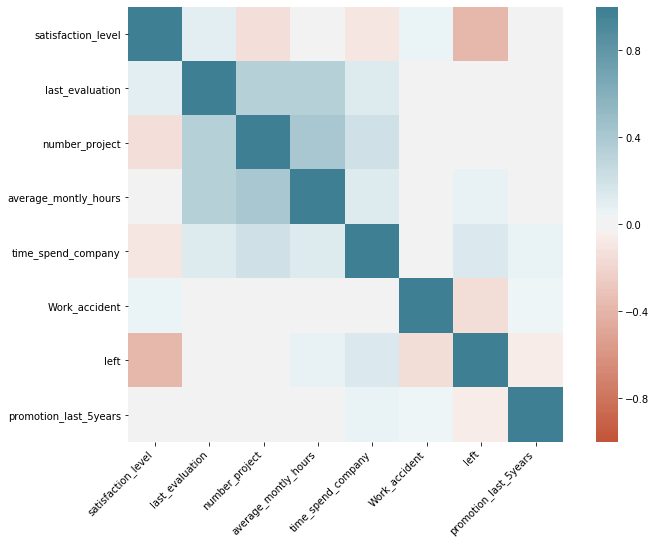

In [209]:
corr = data.corr()
fig, ax = plt.subplots(figsize = (12,8))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);